In [3]:
#!g1.1
tf.__version__

'2.10.1'

In [29]:
!pip install pydot
!pip install graphviz 

     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


In [23]:
#!g1.1
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dense, InputLayer, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Subtract, Concatenate, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
#from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#from PIL import Image

%matplotlib inline

In [2]:
#test
path_img = './imagenet/imagenet/train/'
images = []
img_size = (256, 256)

i = 0
for filename in os.listdir(path_img):
    images.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))
    
    i+=1
    if i==2000: break

In [13]:
#!g1.1
def add_noise_and_convert_to_array (input_img, noise_factor=None, norm=True):
    x_images_clear = []
    x_images_noised = []
    for img in input_img:
        if noise_factor == None:
            noise_factor = np.random.uniform(0.1, 0.3)
        img_np = (image.img_to_array(img)) #.astype('float32')
        igm_np = img_np.astype('float32')
        if norm:
            val_upper = 1.
            img_np /= 255.
        else:
            #img_np = img_np.astype('int')
            val_upper = 255.
        x_images_clear.append(img_np)
        noise = noise_factor*val_upper*K.random_normal(img_np.shape, mean=0., stddev=1.0)               
        #noise = np.zeros(img_np.shape)
        #for element in noise:
        #    element = rng.rvs()
        img_noised = img_np + noise
        img_noised = K.clip(img_noised, 0., val_upper)
        x_images_noised.append(img_noised)
    return np.array(x_images_clear), np.array(x_images_noised)

images_clear, images_noised = add_noise_and_convert_to_array(images, norm=True)

In [2]:
#np.save('images_clear', images_clear)
#np.save('images_noised', images_noised)
images_clear = np.load('images_clear.npy')
images_noised = np.load('images_noised.npy')

In [3]:
images_clear.shape

(2000, 256, 256, 3)

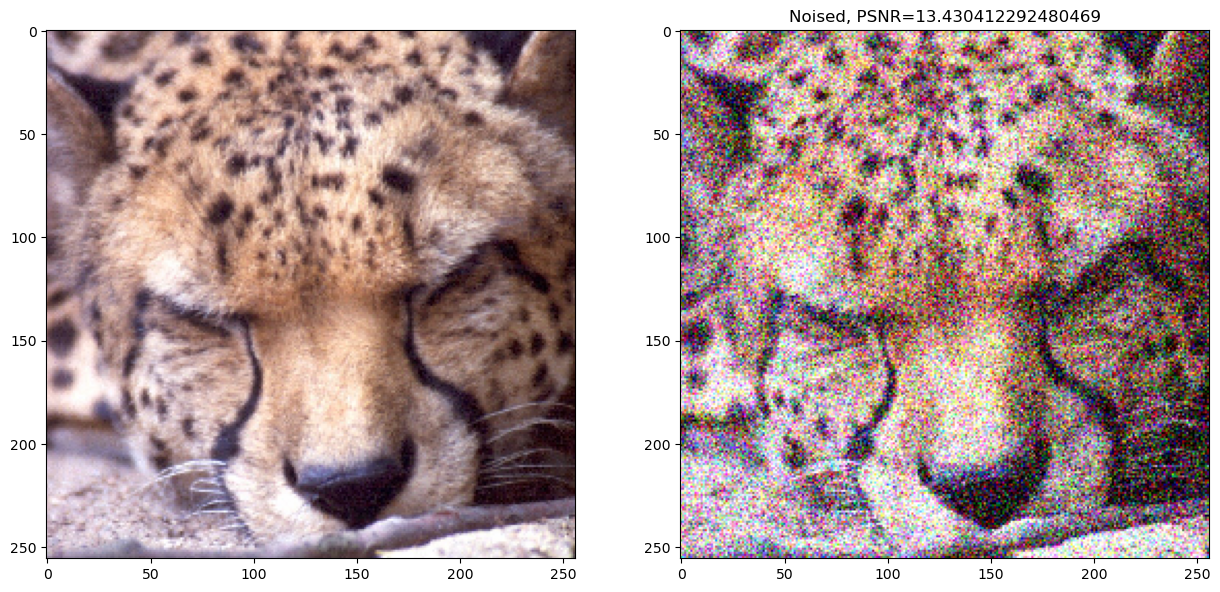

In [3]:
#!g1.1
n=5
max_value=1.
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image.array_to_img(images_clear[n]))
plt.subplot(1,2,2)
plt.title(f'Noised, PSNR={tf.image.psnr(images_clear[n], images_noised[n], max_val=max_value)}')
plt.imshow(image.array_to_img(images_noised[n]))
#image.save_img('t.jpg', image.array_to_img(images_noised[n]))
#image.save_img('tc.jpg', image.array_to_img(images_clear[n]))

In [ ]:
#!g1.1
#model = tf.keras.models.load_model('/kaggle/working/ae_v2_adamax_gelu_100_0.0054')
#model.summary()

In [4]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

In [5]:
def psnr_loss(y_true, y_pred):
    return 1/tf.image.psnr(y_true, y_pred, max_val=255)

def ssim_loss(y_true, y_pred):
    return 1/tf.image.ssim(y_true, y_pred, max_val=1)

def ssim_l2(y_true, y_pred):
    ssim = 1/tf.image.ssim(y_true, y_pred, max_val=1)
    l2 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return ssim + l2

def wloss(y_true, y_pred):
    return K.mean(y_true*y_pred)

combine_loss = ['mae', ssim_loss]

In [6]:
#!g1.1
def plot_result(image_clear, image_noised, image_reconstructed, max_value=255):
    plt.subplots(1,3, figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(image_clear)
    #plt.imshow(image.array_to_img(image_clear))
    #plt.imshow(image_clear)
    plt.title(f'Ground True')
    plt.subplot(1,3,2)
    plt.imshow(image_noised)
    plt.title(f'Noised, PSNR={tf.image.psnr(image_clear, image_noised, max_val=max_value)}')
    plt.subplot(1,3,3)
    plt.imshow(image_reconstructed)
    plt.title(f'Reconstructed, PSNR={tf.image.psnr(image_clear, image_reconstructed, max_val=max_value)}')

In [7]:
def calc_mean_image_metrics(images_clear, images_reconstructed, max_value):
    psnrs = []
    ssims = []
    for i in range(images_reconstructed.shape[0]):
        psnr = tf.image.psnr(images_clear[i], images_reconstructed[i], max_val=max_value)
        psnrs.append(psnr)
        ssim = tf.image.ssim(images_clear[i], images_reconstructed[i], max_val=max_value)
        ssims.append(ssim)
    return np.mean(np.array(psnrs)), np.mean(np.array(ssims))

In [8]:
def predict_all(model, x):
    yy = []
    for i in range(x.shape[0]):
        image = x[i][np.newaxis, :]
        y = model.predict(image)
        yy.append(y[0])
    return np.array(yy)

# Autoencoder

In [19]:
#!g1.1
img_shape=(256, 256, 3)

input = Input(img_shape)
encode = Conv2D(256, kernel_size=(3,3), padding='same')(input)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)
encode = Conv2D(256, kernel_size=(3,3), padding='same')(encode)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)

decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(encode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)
decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(decode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)

out = Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')(decode)

ae = Model(input, out)

ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 256)     7168      
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 256)    1024      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 256)     5900

Epoch 1/30
1600/1600 [==============================] - 149s 91ms/step - loss: 2.9547 - val_loss: 1.9708 - lr: 0.0100
Epoch 2/30
1600/1600 [==============================] - 141s 88ms/step - loss: 2.0756 - val_loss: 1.8309 - lr: 0.0100
Epoch 3/30
1600/1600 [==============================] - 143s 89ms/step - loss: 1.9581 - val_loss: 2.5810 - lr: 0.0100
Epoch 4/30
1600/1600 [==============================] - 145s 91ms/step - loss: 1.8322 - val_loss: 1.7069 - lr: 0.0100
Epoch 5/30
1600/1600 [==============================] - 156s 97ms/step - loss: 1.7484 - val_loss: 1.6448 - lr: 0.0100
Epoch 6/30
1600/1600 [==============================] - 155s 97ms/step - loss: 1.6928 - val_loss: 1.6390 - lr: 0.0100
Epoch 7/30
1600/1600 [==============================] - 158s 99ms/step - loss: 1.6540 - val_loss: 1.6057 - lr: 0.0100
Epoch 8/30
1600/1600 [==============================] - 160s 100ms/step - loss: 1.6201 - val_loss: 1.5868 - lr: 0.0100
Epoch 9/30
1600/1600 [==============================] -

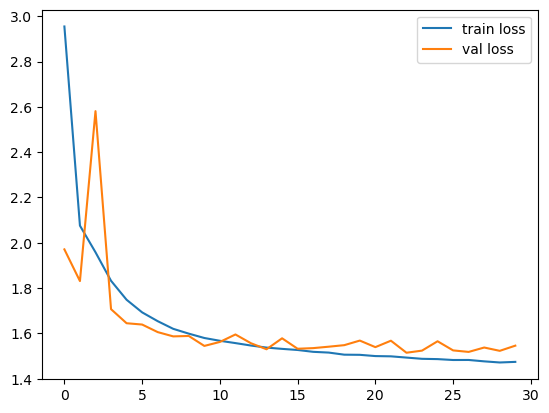

In [20]:
#!g1.1
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

ae.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = ae.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                batch_size=1)

plot_history(history)

In [21]:
y = predict_all(ae, images_noised)

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 46ms/step


mean PSNR=22.291637420654297
mean SSIM=0.6661742925643921


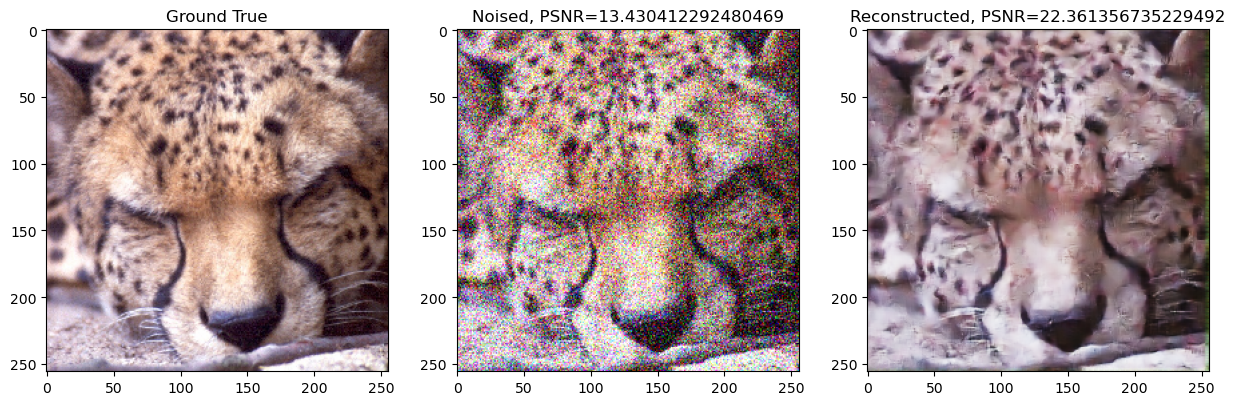

In [22]:
#!g1.1
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [95]:
tf.image.psnr()

(256, 256, 3)

In [ ]:
1 / np.sqrt(3780.8225)
np.log10(0.016263231932649298)
#20 * np.log10(1 / np.sqrt(3780.8225))

a = tf.image.psnr(images_clear[1], y[1], max_val=1)
print (a.numpy())

In [43]:
ae_v3.save('ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best')

INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


In [ ]:
ae_v2.optimizer.variables()

# dnCNN

In [28]:
img_shape=(256, 256, 3)
input = Input(img_shape)
hidden = 16
x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
x = Activation('gelu')(x)
for i in range(hidden):
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('gelu')(x)
x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
out = Subtract()([input, x])

dncnn = Model(input, out)
dncnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 256, 256, 25  7168        ['input_4[0][0]']                
                                6)                                                                
                                                                                                  
 activation_43 (Activation)     (None, 256, 256, 25  0           ['conv2d_46[0][0]']              
                                6)                                                          

                                                                                                  
 conv2d_55 (Conv2D)             (None, 256, 256, 3)  6915        ['activation_51[0][0]']          
                                                                                                  
 subtract_3 (Subtract)          (None, 256, 256, 3)  0           ['input_4[0][0]',                
                                                                  'conv2d_55[0][0]']              
                                                                                                  
Total params: 4,742,915
Trainable params: 4,738,819
Non-trainable params: 4,096
__________________________________________________________________________________________________


In [15]:
def dncnn_res(img_shape):

    input = Input(img_shape)
    hidden = 16
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(hidden):
        xx = Conv2D(128, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    return model
#dncnn = dncnn_res((256,256,3))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 256, 256, 12  3584        ['input_5[0][0]']                
                                8)                                                                
                                                                                                  
 activation_68 (Activation)     (None, 256, 256, 12  0           ['conv2d_72[0][0]']              
                                8)                                                          

                                                                                                  
 conv2d_79 (Conv2D)             (None, 256, 256, 12  147584      ['add_69[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_70 (BatchN  (None, 256, 256, 12  512        ['conv2d_79[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_75 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_70[0][0]'] 
                                8)                                                                
                                                                                                  
 add_70 (A

                                8)                                'activation_81[0][0]']          
                                                                                                  
 conv2d_86 (Conv2D)             (None, 256, 256, 12  147584      ['add_76[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_77 (BatchN  (None, 256, 256, 12  512        ['conv2d_86[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_82 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_77[0][0]'] 
                                8)                                                                
          

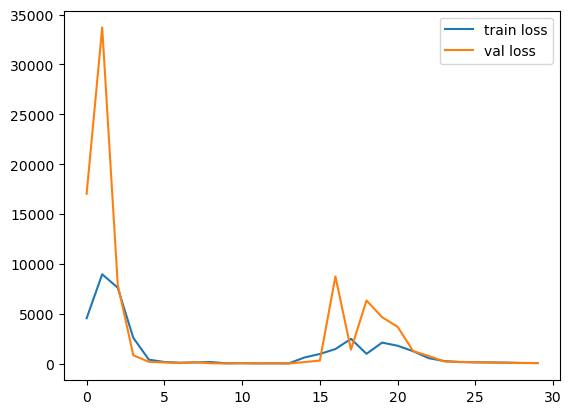

In [22]:
dncnn = dncnn_res((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

dncnn.compile(optimizer=Adamax(learning_rate=1e-2), loss='mae')

history = dncnn.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                shuffle=True,
                batch_size=1)

plot_history(history)

In [23]:
y = predict_all(dncnn, images_noised)

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=-10.880854606628418
mean SSIM=0.05120759457349777


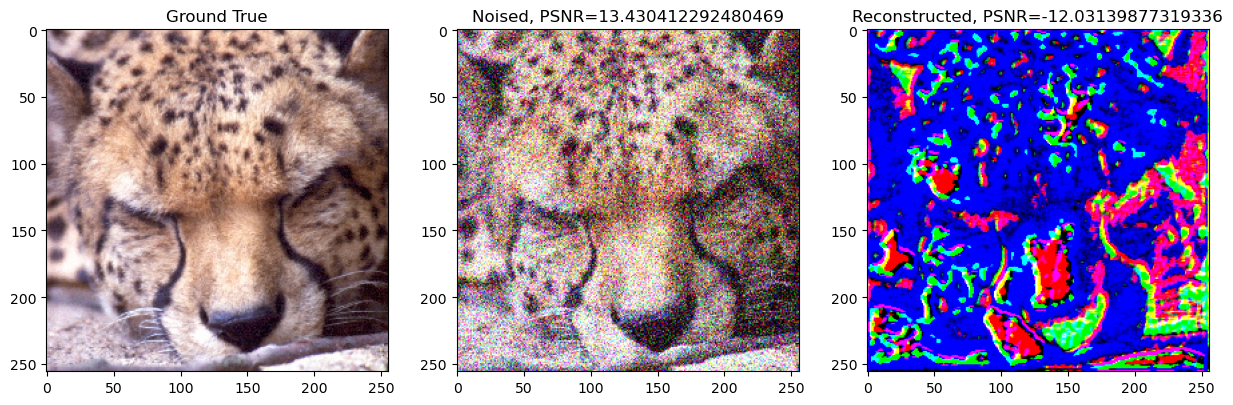

In [24]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# RAW

In [52]:
!pip install rawpy
!pip install imageio

     -------------------------------------- 793.6/793.6 kB 6.3 MB/s eta 0:00:00


In [70]:
import rawpy
import scipy as sp
import statsmodels


In [75]:
raw = rawpy.imread('raw_noise/high_iso/test_0001.CR3')

(4498, 6742, 3)


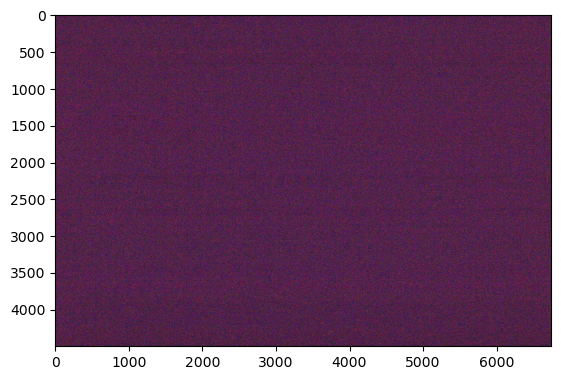

In [76]:
rgb = raw.postprocess(use_camera_wb=True, output_color=rawpy.ColorSpace.sRGB)
print (rgb.shape)
plt.imshow(rgb)

In [77]:
vec=rgb.flatten()

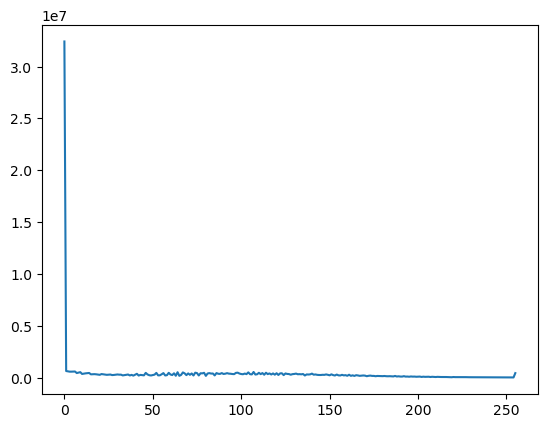

In [79]:
vec_counts = np.unique(vec, return_counts=True)
plt.plot(vec_counts[0], vec_counts[1])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f488d26a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1f488d26fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f488d26760>],
 'medians': [<matplotlib.lines.Line2D at 0x1f488d4e5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f488d4e880>],
 'means': []}

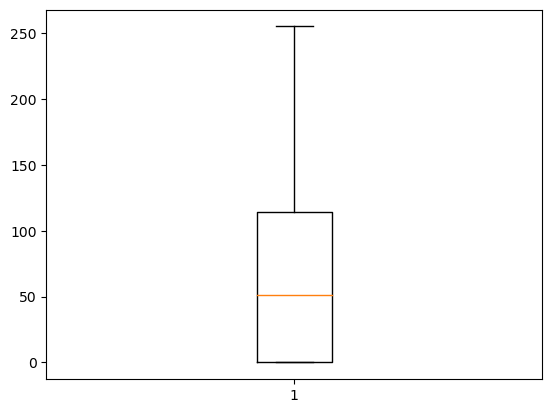

In [73]:
plt.boxplot(vec)

In [80]:
from scipy.stats.sampling import DiscreteGuideTable

In [84]:
vec

array([  0,  99,   0, ...,   0, 106,   0], dtype=uint8)

1.0000000000000004


(array([4540.,  777.,  970., 1016.,  939.,  753.,  461.,  287.,  134.,
         123.]),
 array([  0. ,  24.4,  48.8,  73.2,  97.6, 122. , 146.4, 170.8, 195.2,
        219.6, 244. ]),
 <BarContainer object of 10 artists>)

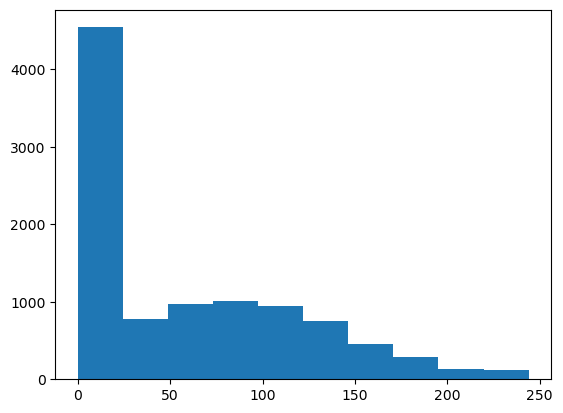

In [85]:
vec_p = vec_counts[1]/len(vec)
print (sum(vec_p))
rng = DiscreteGuideTable(vec_p)

xx = []
for i in range(10000):
    xx.append(rng.rvs())
    
plt.hist(xx)

In [183]:
def noise():
    x = rng.rvs()
    print (x)
    yield x
    
    
x = np.fromiter(noise()) #, dtype=(int, (1,10)))
x

TypeError: fromiter() missing required argument 'dtype' (pos 2)

In [181]:
def cut_image(image):
    subimages = []
    
    
    return subimages

# Unet

In [5]:
def model_unet(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_concat = Add()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_concat)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_concat = Add()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_concat)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_concat = Add()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_concat)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_concat = Add()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_concat)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    #out = Add()([input, conv_out])
    out = conv_out

    model = Model(input, out)
    model.summary()
    
    return model

In [23]:
unet = model_unet((256, 256, 3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

unet.compile(optimizer=Adamax(learning_rate=1e-2), loss='mae')

history = unet.fit(images_noised, images_clear,
                epochs=50,
                callbacks=[reduce_lr],
                validation_split=0.2,
                #huffle=True,
                batch_size=1)

plot_history(history)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  832         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  16448       ['conv2d_19[0][0]']              
                                )                                                           

                                8)                                'conv2d_22[0][0]']              
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 128, 12  512        ['add_7[0][0]']                  
 ormalization)                  8)                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 128, 128, 12  65664       ['batch_normalization_14[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 12  65664       ['conv2d_33[0][0]']              
                                8)                                                                
          

KeyboardInterrupt: 

In [27]:
y = predict_all(unet, images_noised)

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=21.118940353393555
mean SSIM=0.6538915634155273


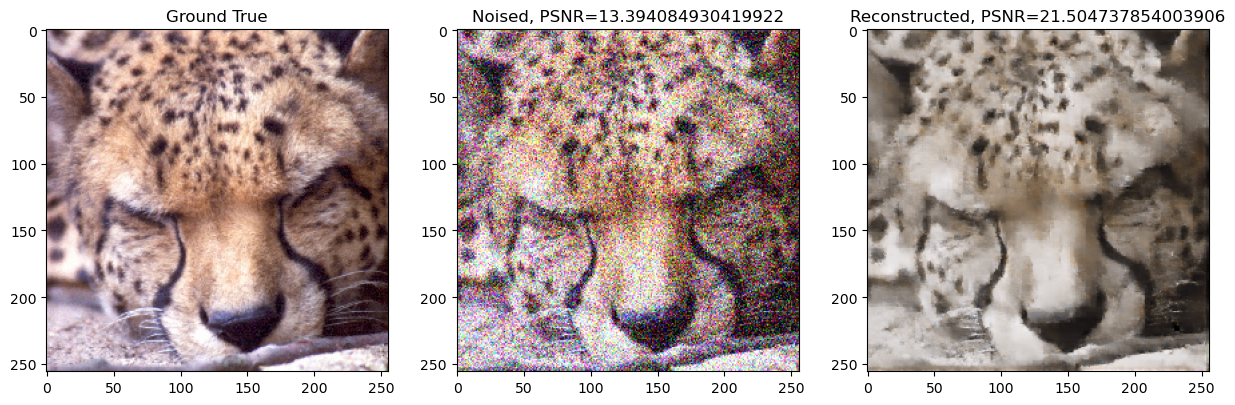

In [28]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# GAN

In [46]:
def dncnn_res_gan(img_shape):

    input = Input(img_shape)
    hidden = 16
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
    x = LeakyReLU(0.2)(x)
    for i in range(hidden):
        xx = Conv2D(128, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = LeakyReLU(0.2)(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')(x)
    #out = Subtract()([input, x])
    out = x

    model = Model(input, out)
    model.summary()
    return model

In [47]:
def generator():
    #model = model_unet((256, 256, 3))
    model = dncnn_res_gan((256,256,3))  
    return model

In [48]:
def discriminator():
    img_shape=(256, 256, 3)

    input = Input(img_shape)
    x = Conv2D(64, kernel_size=(3,3), padding='same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    out = Dense(1)(x)

    model = Model(input, out)
    model.summary()
    return model

In [49]:
class denoiser_gan(Model):
    
    img_shape = (256, 256, 3)
    
    def __init__(self, generator, discriminator):
        super (denoiser_gan, self).__init__()
        self.G = generator
        self.D = discriminator
                
    def compile (self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(denoiser_gan, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    
    def train_step(self, data):        
        images_noised, images_clear = data

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

            images_reconstructed = self.G(images_noised, training=True)

            real_out = self.D(images_clear, training=True)
            fake_out = self.D(images_reconstructed + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)
            
            g_loss_1 = tf.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)(tf.ones_like(fake_out), fake_out)
            g_loss_2 = tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            #g_loss = tf.constant([0.9])*g_loss_1 + tf.constant([0.1])*g_loss_2
            g_loss = g_loss_2
            
            d_real_loss = tf.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)(tf.ones_like(real_out), real_out)
            d_fake_loss = tf.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)(tf.zeros_like(fake_out), fake_out)
            d_total_loss = d_real_loss + d_fake_loss
            d_loss = d_total_loss
            
        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        
        self.g_optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss}
            
    def call(self, inputs):
        return self.model(inputs)
    
    def predict(self, inputs):
        return self.G.predict(inputs)
    
    #############################   tf.print()

In [50]:
batch_size = 1
G = generator()
D = discriminator()
dngan = denoiser_gan(G, D)
g_opt = Adam(learning_rate=2e-4, beta_1=0.5)
d_opt = Adam(learning_rate=2e-4, beta_1=0.5)
g_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

reduce_g_lr = callbacks.ReduceLROnPlateau(monitor='g_loss',
                                        factor=0.1,
                                        patience=5)
reduce_d_lr = callbacks.ReduceLROnPlateau(monitor='d_loss',
                                        factor=0.1,
                                        patience=5)

dngan.compile(g_opt,
              d_opt,
              g_loss,
              d_loss)
history = dngan.fit(images_noised[:100], images_clear[:100],
                    epochs=300,
                    batch_size=1,
                    callbacks=[reduce_g_lr] #, reduce_d_lr]
                   )

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_89 (Conv2D)             (None, 256, 256, 12  3584        ['input_10[0][0]']               
                                8)                                                                
                                                                                                  
 leaky_re_lu_63 (LeakyReLU)     (None, 256, 256, 12  0           ['conv2d_89[0][0]']              
                                8)                                                          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 12  147584      ['add_69[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_83 (BatchN  (None, 256, 256, 12  512        ['conv2d_96[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 leaky_re_lu_70 (LeakyReLU)     (None, 256, 256, 12  0           ['batch_normalization_83[0][0]'] 
                                8)                                                                
                                                                                                  
 add_70 (A

                                8)                                'leaky_re_lu_76[0][0]']         
                                                                                                  
 conv2d_103 (Conv2D)            (None, 256, 256, 12  147584      ['add_76[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_90 (BatchN  (None, 256, 256, 12  512        ['conv2d_103[0][0]']             
 ormalization)                  8)                                                                
                                                                                                  
 leaky_re_lu_77 (LeakyReLU)     (None, 256, 256, 12  0           ['batch_normalization_90[0][0]'] 
                                8)                                                                
          

100/100 [==============================] - 26s 256ms/step - d_loss: 7.3003 - g_loss: 0.1263 - lr: 0.0010
Epoch 5/300
100/100 [==============================] - 25s 250ms/step - d_loss: 3.1910 - g_loss: 0.1162 - lr: 0.0010
Epoch 6/300
100/100 [==============================] - 25s 254ms/step - d_loss: 3.0622 - g_loss: 0.1117 - lr: 0.0010
Epoch 7/300
100/100 [==============================] - 27s 266ms/step - d_loss: 1.9482 - g_loss: 0.1116 - lr: 0.0010
Epoch 8/300
100/100 [==============================] - 26s 260ms/step - d_loss: 1.1430 - g_loss: 0.1119 - lr: 0.0010
Epoch 9/300
100/100 [==============================] - 26s 261ms/step - d_loss: 0.8436 - g_loss: 0.1036 - lr: 0.0010
Epoch 10/300
100/100 [==============================] - 26s 257ms/step - d_loss: 0.6689 - g_loss: 0.1000 - lr: 0.0010
Epoch 11/300
100/100 [==============================] - 27s 272ms/step - d_loss: 0.5766 - g_loss: 0.0992 - lr: 0.0010
Epoch 12/300
100/100 [==============================] - 27s 270ms/step - d

100/100 [==============================] - 24s 240ms/step - d_loss: 0.5588 - g_loss: 0.0639 - lr: 1.0000e-13
Epoch 72/300
100/100 [==============================] - 25s 252ms/step - d_loss: 0.5205 - g_loss: 0.0621 - lr: 1.0000e-13
Epoch 73/300
100/100 [==============================] - 25s 254ms/step - d_loss: 0.5370 - g_loss: 0.0637 - lr: 1.0000e-14
Epoch 74/300
100/100 [==============================] - 24s 245ms/step - d_loss: 0.4375 - g_loss: 0.0791 - lr: 1.0000e-14
Epoch 75/300
100/100 [==============================] - 25s 246ms/step - d_loss: 0.4320 - g_loss: 0.0663 - lr: 1.0000e-14
Epoch 76/300
100/100 [==============================] - 25s 253ms/step - d_loss: 0.4344 - g_loss: 0.0634 - lr: 1.0000e-14
Epoch 77/300
100/100 [==============================] - 25s 248ms/step - d_loss: 0.4278 - g_loss: 0.0621 - lr: 1.0000e-14
Epoch 78/300
100/100 [==============================] - 25s 246ms/step - d_loss: 0.4361 - g_loss: 0.0616 - lr: 1.0000e-15
Epoch 79/300
100/100 [===============

Epoch 138/300
100/100 [==============================] - 24s 243ms/step - d_loss: 0.4342 - g_loss: 0.0535 - lr: 1.0000e-25
Epoch 139/300
100/100 [==============================] - 24s 243ms/step - d_loss: 0.4752 - g_loss: 0.0522 - lr: 1.0000e-25
Epoch 140/300
100/100 [==============================] - 25s 246ms/step - d_loss: 0.5152 - g_loss: 0.0538 - lr: 1.0000e-25
Epoch 141/300
100/100 [==============================] - 25s 249ms/step - d_loss: 0.4907 - g_loss: 0.0540 - lr: 1.0000e-25
Epoch 142/300
100/100 [==============================] - 25s 247ms/step - d_loss: 0.4434 - g_loss: 0.0534 - lr: 1.0000e-25
Epoch 143/300
100/100 [==============================] - 25s 249ms/step - d_loss: 0.4871 - g_loss: 0.0539 - lr: 1.0000e-25
Epoch 144/300
100/100 [==============================] - 23s 235ms/step - d_loss: 0.4739 - g_loss: 0.0551 - lr: 1.0000e-26
Epoch 145/300
100/100 [==============================] - 24s 244ms/step - d_loss: 0.4544 - g_loss: 0.0541 - lr: 1.0000e-26
Epoch 146/300
10

100/100 [==============================] - 24s 243ms/step - d_loss: 0.6411 - g_loss: 0.0497 - lr: 1.0000e-36
Epoch 205/300
100/100 [==============================] - 24s 243ms/step - d_loss: 0.4770 - g_loss: 0.0495 - lr: 1.0000e-37
Epoch 206/300
100/100 [==============================] - 24s 245ms/step - d_loss: 0.4846 - g_loss: 0.0501 - lr: 1.0000e-37
Epoch 207/300
100/100 [==============================] - 24s 244ms/step - d_loss: 0.4933 - g_loss: 0.0504 - lr: 1.0000e-37
Epoch 208/300
100/100 [==============================] - 24s 242ms/step - d_loss: 0.4635 - g_loss: 0.0508 - lr: 1.0000e-37
Epoch 209/300
100/100 [==============================] - 25s 247ms/step - d_loss: 0.4380 - g_loss: 0.0503 - lr: 1.0000e-37
Epoch 210/300
100/100 [==============================] - 24s 244ms/step - d_loss: 0.4459 - g_loss: 0.0516 - lr: 1.0000e-38
Epoch 211/300
100/100 [==============================] - 24s 241ms/step - d_loss: 0.4612 - g_loss: 0.0507 - lr: 1.0000e-38
Epoch 212/300
100/100 [=======

100/100 [==============================] - 24s 239ms/step - d_loss: 0.4887 - g_loss: 0.0479 - lr: 0.0000e+00
Epoch 271/300
100/100 [==============================] - 25s 247ms/step - d_loss: 0.4530 - g_loss: 0.0481 - lr: 0.0000e+00
Epoch 272/300
100/100 [==============================] - 24s 238ms/step - d_loss: 0.4544 - g_loss: 0.0493 - lr: 0.0000e+00
Epoch 273/300
100/100 [==============================] - 25s 248ms/step - d_loss: 0.4415 - g_loss: 0.0486 - lr: 0.0000e+00
Epoch 274/300
100/100 [==============================] - 24s 237ms/step - d_loss: 0.4342 - g_loss: 0.0480 - lr: 0.0000e+00
Epoch 275/300
100/100 [==============================] - 24s 242ms/step - d_loss: 0.4328 - g_loss: 0.0479 - lr: 0.0000e+00
Epoch 276/300
100/100 [==============================] - 25s 247ms/step - d_loss: 0.4500 - g_loss: 0.0473 - lr: 0.0000e+00
Epoch 277/300
100/100 [==============================] - 24s 242ms/step - d_loss: 0.4407 - g_loss: 0.0471 - lr: 0.0000e+00
Epoch 278/300
100/100 [=======

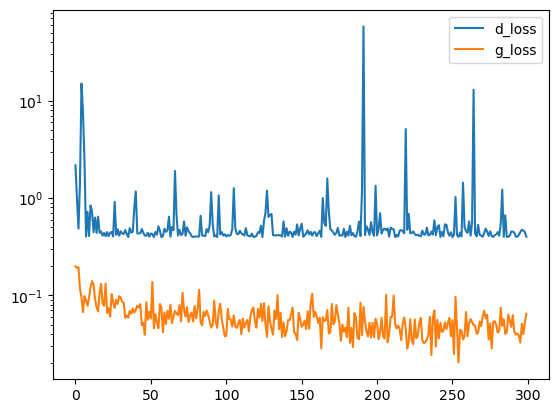

In [53]:
#history = dngan.history
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.yscale('log')
plt.legend()
plt.show()

In [54]:
test = images_noised[:6]
a = dngan.predict(test)

1/1 [==============================] - 1s 698ms/step


In [59]:
y = predict_all(dngan, images_noised)

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 53ms/step


mean PSNR=24.13494873046875
mean SSIM=0.6654396653175354


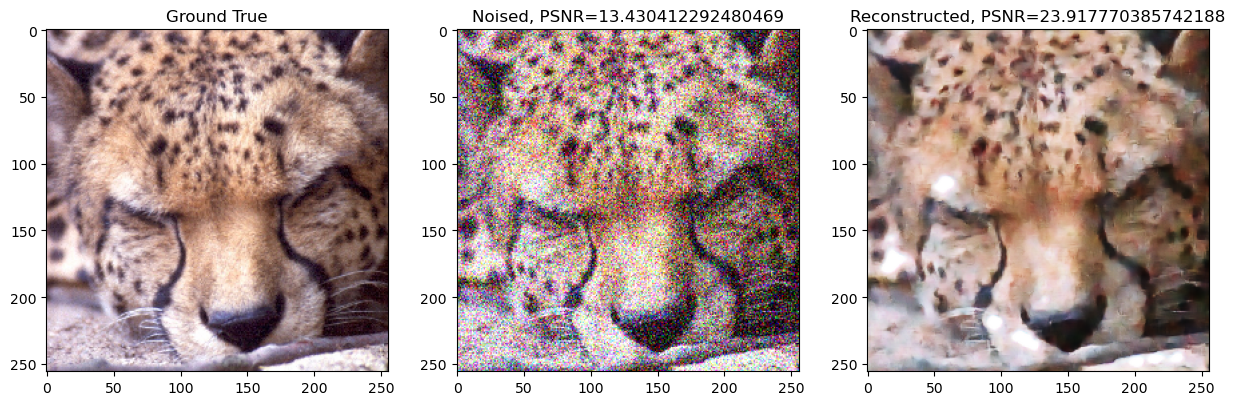

In [60]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [55]:
a[1]

array([[[0.3331228 , 0.41078058, 0.3722851 ],
        [0.3429597 , 0.36544102, 0.27820855],
        [0.34601444, 0.34777555, 0.3068404 ],
        ...,
        [0.35350814, 0.4184489 , 0.38983855],
        [0.35054037, 0.39966604, 0.3551165 ],
        [0.41349274, 0.45331326, 0.44288334]],

       [[0.46437472, 0.48172048, 0.43324235],
        [0.40536904, 0.41566348, 0.36195442],
        [0.4327909 , 0.3965069 , 0.35340455],
        ...,
        [0.4258593 , 0.46071416, 0.4264727 ],
        [0.4174049 , 0.4755561 , 0.41919094],
        [0.48856914, 0.48884752, 0.47511783]],

       [[0.34329998, 0.38008547, 0.3561417 ],
        [0.34472573, 0.3624058 , 0.32712895],
        [0.3278924 , 0.34702432, 0.31043148],
        ...,
        [0.46853313, 0.49547783, 0.47045717],
        [0.4317282 , 0.4692454 , 0.4292794 ],
        [0.44716954, 0.49484864, 0.46118468]],

       ...,

       [[0.07640423, 0.07787805, 0.07468147],
        [0.05766488, 0.06449894, 0.05502699],
        [0.0571862 , 0

tf.Tensor(23.917992, shape=(), dtype=float32)


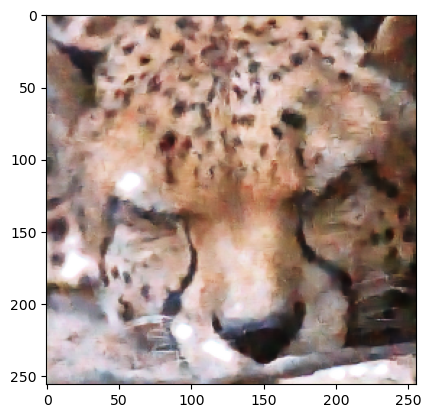

In [57]:
plt.imshow(a[5])
print(tf.image.psnr(images_clear[5], a[5], max_val=1.))

In [64]:
#G.save('gan/G')
#D.save('gan/D')
#dngan.fit(images_noised[:100], images_clear[:100], epochs=1)
dngan.save('gan/dngan')
#dngan.save_weights('gan/dngan_weights')

ResourceExhaustedError: Graph execution error:

Detected at node 'model_6/batch_normalization_77/FusedBatchNormV3' defined at (most recent call last):
    File "C:\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\basil\AppData\Local\Temp\ipykernel_9064\3246040459.py", line 3, in <module>
      dngan.fit(images_noised[:100], images_clear[:100], epochs=1)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\basil\AppData\Local\Temp\ipykernel_9064\3721669758.py", line 23, in train_step
      images_reconstructed = self.G(images_noised, training=True)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_6/batch_normalization_77/FusedBatchNormV3'
OOM when allocating tensor with shape[32,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_6/batch_normalization_77/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_829268]